In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.style.use('fivethirtyeight')
%matplotlib inline

from keras.datasets import mnist

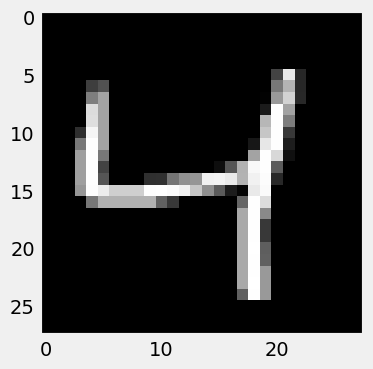

In [2]:

(train_X, train_y), (test_X, test_y) = mnist.load_data()
images, labels = train_X, train_y

plt.figure(figsize=(4,4))
plt.imshow(images[2].reshape(28,28), cmap='gray')
plt.grid(False)


In [3]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
def normalize(X):
    """Normalize the given dataset X to have zero mean.
    Args:
        X: ndarray, dataset of shape (N,D) where D is the dimension of the data,
           and N is the number of datapoints
    
    Returns:
        (Xbar, mean): tuple of ndarray, Xbar is the normalized dataset
        with mean 0; mean is the sample mean of the dataset.
    """
    # YOUR CODE HERE
    ### Uncomment and modify the code below
    N, D = X.shape
    mu = np.mean(X, axis=0)
    Xbar = X - mu            # <-- EDIT THIS, compute the normalized data Xbar by subtracting mu from each row of X
    return Xbar, mu

In [5]:
def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix

    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    # YOUR CODE HERE
    # Uncomment and modify the code below
#     # Compute the eigenvalues and eigenvectors
#     # Note that you can compute both of these with just a single function call
    eigvals, eigvecs = np.linalg.eig(S)
  
#     # The eigenvalues and eigenvectors need to be sorted in descending order according to the eigenvalues
#     # We will use `np.argsort` to find a permutation of the indices of eigvals that will sort eigvals in ascending order and
#     # then find the descending order via [::-1], which reverse the indices
#     # (https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html)
    sort_indices = np.argsort(eigvals)[::-1]
  
#     # Notice that we are sorting the columns (not rows) of eigvecs since the columns represent the eigenvectors.
    return eigvals[sort_indices], eigvecs[:, sort_indices]

In [6]:
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    # YOUR CODE HERE
    # Uncomment and modify the code below
    return B@np.linalg.inv(B.T @ B)@B.T

In [7]:
def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        the reconstructed data, the sample mean of the X, principal values
        and principal components
    """

    print("X shape = ", X.shape)
    # YOUR CODE HERE
    # your solution should take advantage of the functions you have implemented above.
    ### Uncomment and modify the code below
    # first perform normalization on the digits so that they have zero mean and unit variance
    X_normalized, mean = normalize(X)
    print("X_normalized shape = ", X_normalized.shape)
    # Then compute the data covariance matrix S
    S = np.cov(X_normalized, rowvar=False, bias=True)

    # Next find eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eig(S)
    print("eig_vecs shape = ", eig_vecs.shape)
    # Take the top `num_components` of eig_vals and eig_vecs,
    # This will be the corresponding principal values and components
    # Remember that the eigenvectors are the columns of the matrix `eig_vecs`
    principal_vals, principal_components = eig_vals[:num_components], eig_vecs[:, :num_components]

    # Due to precision errors, the eigenvectors might come out to be complex, so only take their real parts
    principal_components = np.real(principal_components) 
    print("principal_components shape = ", principal_components.shape)
    # Reconstruct the data by projecting the normalized data on the basis spanned by the principal components
    # Remember that the data points in X_normalized are arranged along the rows
    # but while projecting, we need them to be arranged along the columns
    # Notice that we have subtracted the mean from X so make sure that you add it back
    # to the reconstructed data
    pmatrix = projection_matrix(principal_components)
    print("pmatrix shape = ", pmatrix.shape)

    reconst = (pmatrix @ X_normalized.T).T
    reconst = reconst + mean

    return reconst, mean, principal_vals, principal_components

reconst, _, _, _ = PCA(X, num_components=25)

X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 25)
pmatrix shape =  (784, 784)


X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 25)
pmatrix shape =  (784, 784)


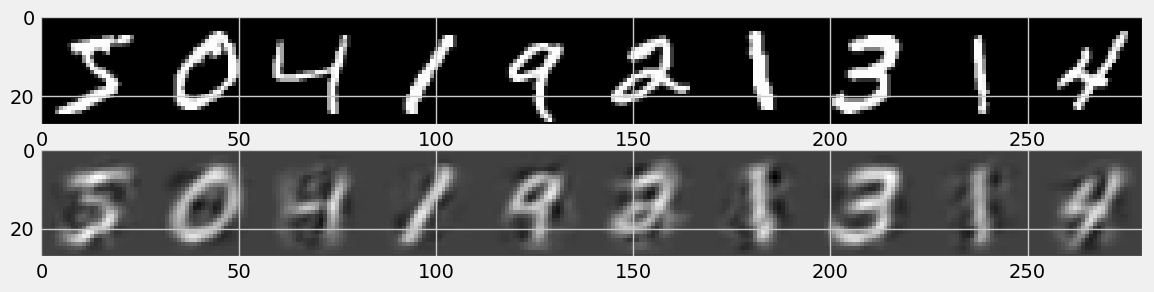

In [8]:
reconst, _, _, _ = PCA(X, num_components=25)
num_images_to_show = 10
reconst_images = np.reshape(reconst[:num_images_to_show], (-1, 28, 28))
fig, ax = plt.subplots(2, 1, figsize=(num_images_to_show * 3, 3))
ax[0].imshow(np.concatenate(np.reshape(X[:num_images_to_show], (-1, 28, 28)), -1), cmap="gray")
ax[1].imshow(np.concatenate(reconst_images, -1), cmap="gray")

In [9]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [10]:
loss = []
reconstructions = []
# iterate over different number of principal components, and compute the MSE
for num_component in range(1, 100, 5):
    reconst, _, _, _ = PCA(X, num_component)
    error = mse(reconst, X)
    reconstructions.append(reconst)
    print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions
loss = np.asarray(loss)

X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 1)
pmatrix shape =  (784, 784)
n = 1, reconstruction_error = 46.465431
X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 6)
pmatrix shape =  (784, 784)
n = 6, reconstruction_error = 31.284116
X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 11)
pmatrix shape =  (784, 784)
n = 11, reconstruction_error = 24.259506
X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 16)
pmatrix shape =  (784, 784)
n = 16, reconstruction_error = 19.831531
X shape =  (1000, 784)
X_normalized shape =  (1000, 784)
eig_vecs shape =  (784, 784)
principal_components shape =  (784, 21)
pmatrix shape =  (784, 784)
n = 21, reconstruction_error = 16.731753
X shape =  (1000, 784)
X_norm

In [11]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss, columns=['no. of components', 'mse']).head()

,no. of components,mse
0,1.0,46.465431
1,6.0,31.284116
2,11.0,24.259506
3,16.0,19.831531
4,21.0,16.731753


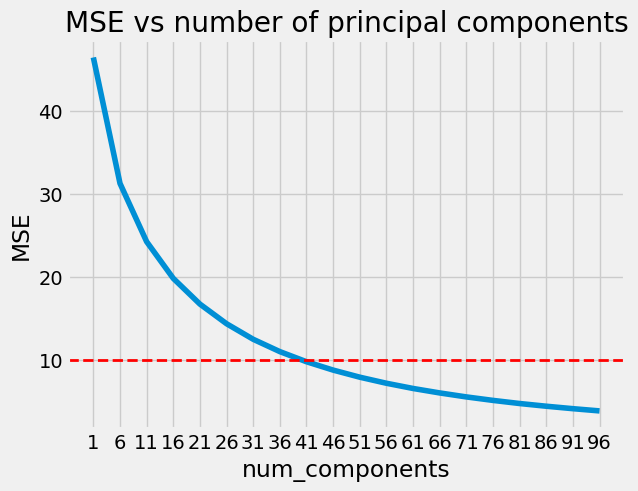

In [12]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(10, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But numbers don't tell us everything! Just what does it mean qualitatively for the loss to decrease from around  45.0
  to less than  10.0?

Let's find out! In the next cell, we draw the the leftmost image is the original digit. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [13]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

interactive(children=(IntSlider(value=500, description='image_idx', max=1000), Output()), _dom_classes=('widge…

In [16]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :]).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…